In [1]:
import mlflow
import mlflow.keras as mlflowKeras
import mlflow.tensorflow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec
from azureml.core import Workspace
from azureml.core.model import Model


import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

from pyngrok import ngrok
from getpass import getpass

import joblib

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

from datetime import datetime
from dotenv import load_dotenv
import os

2024-12-06 21:34:10.530287: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 21:34:10.545992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 21:34:10.564245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 21:34:10.569724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 21:34:10.583290: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# Levanto el servicio de MLFlow
get_ipython().system_raw("mlflow ui --port 5000 &")

# Termino los tuneles abiertos 
ngrok.kill()

[2024-12-06 21:34:39 +0000] [22924] [INFO] Starting gunicorn 22.0.0
[2024-12-06 21:34:39 +0000] [22924] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-12-06 21:34:39 +0000] [22924] [ERROR] Retrying in 1 second.
[2024-12-06 21:34:40 +0000] [22924] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-12-06 21:34:40 +0000] [22924] [ERROR] Retrying in 1 second.
[2024-12-06 21:34:41 +0000] [22924] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-12-06 21:34:41 +0000] [22924] [ERROR] Retrying in 1 second.
[2024-12-06 21:34:42 +0000] [22924] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-12-06 21:34:42 +0000] [22924] [ERROR] Retrying in 1 second.
[2024-12-06 21:34:43 +0000] [22924] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-12-06 21:34:43 +0000] [22924] [ERROR] Retrying in 1 second.
[2024-12-06 21:34:44 +0000] [22924] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.


In [3]:
#Cargo las variables de entorno
load_dotenv()

# Accedo al token de autentificación para iniciar la aplicación en Ngrok
NGROK_AUTH_TOKEN = os.environ.get('NGROK_TOKEN')

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://0e14-52-147-172-125.ngrok-free.app


In [5]:
#Establezco una semilla
np.random.seed(42)

In [6]:
#Cargo los datos
dataset = pd.read_csv('./uk_weather.csv', parse_dates=["datetime","sunrise","sunset"], index_col=["datetime"])

#Relleno de 0 los NaN
dataset.fillna(0, inplace=True)

#Cambio el tipo de dato para optimizar el espacio en memoria
def change_type():

  dataset['tempmax'] = dataset['tempmax'].astype(np.float16)
  dataset['tempmin'] = dataset['tempmin'].astype(np.float16)
  dataset['temp'] = dataset['temp'].astype(np.float16)
  dataset['windspeed'] = dataset['windspeed'].astype(np.float16)
  dataset['winddir'] = dataset['winddir'].astype(np.float32)
  dataset['cloudcover'] = dataset['cloudcover'].astype(np.float32)
  dataset['solarradiation'] = dataset['solarradiation'].astype(np.float32)
  dataset['solarenergy'] = dataset['solarenergy'].astype(np.float16)
  dataset['uvindex'] = dataset['uvindex'].astype(np.int8)
change_type()

In [7]:
dataset = dataset.sort_index()
dataset.head()

,tempmax,tempmin,temp,windspeed,winddir,cloudcover,solarradiation,solarenergy,uvindex,sunrise,sunset
datetime,,,,,,,,,,,
2016-09-17,16.09375,13.601562,15.000000,20.093750,337.000000,86.000000,48.500000,4.398438,2,2016-09-17 06:39:02,2016-09-17 19:09:41
2016-09-18,19.09375,14.898438,16.906250,11.500000,335.799988,94.500000,106.099998,9.101562,4,2016-09-18 06:40:38,2016-09-18 19:07:22
2016-09-19,19.59375,14.601562,17.203125,10.203125,309.799988,71.099998,75.800003,6.601562,4,2016-09-19 06:42:14,2016-09-19 19:05:04
2016-09-20,18.59375,14.296875,16.500000,9.703125,18.200001,84.300003,58.900002,5.000000,3,2016-09-20 06:43:50,2016-09-20 19:02:45
2016-09-21,22.09375,15.101562,18.000000,16.796875,164.699997,54.700001,149.500000,13.000000,5,2016-09-21 06:45:27,2016-09-21 19:00:27


In [8]:
dataset.describe()

,tempmax,tempmin,temp,windspeed,winddir,cloudcover,solarradiation,solarenergy,uvindex
count,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000
mean,15.929688,9.023438,12.375000,21.015625,196.794250,60.414806,84.263260,7.253906,3.809142
std,6.402344,4.960938,5.441406,7.730469,91.396065,25.028852,64.308136,5.566406,2.547993
min,-1.200195,-4.500000,-3.199219,4.601562,0.100000,0.000000,2.600000,0.000000,0.000000
25%,11.101562,5.500000,8.296875,15.500000,128.600006,43.400002,30.000000,2.599609,2.000000
50%,15.500000,9.101562,12.000000,20.000000,221.199997,63.700001,66.400002,5.800781,3.000000
75%,20.593750,12.796875,16.703125,25.500000,259.299988,80.500000,124.699997,10.796875,6.000000
max,39.812500,22.093750,30.296875,63.500000,359.600006,100.000000,336.500000,29.093750,10.000000


In [9]:
dataset.tail()

,tempmax,tempmin,temp,windspeed,winddir,cloudcover,solarradiation,solarenergy,uvindex,sunrise,sunset
datetime,,,,,,,,,,,
2024-11-26,10.296875,5.300781,7.398438,13.500000,222.699997,32.900002,22.5,1.799805,2,2024-11-26 07:37:15,2024-11-26 15:58:20
2024-11-27,9.101562,2.599609,6.398438,20.296875,331.700012,73.300003,7.0,0.700195,0,2024-11-27 07:38:46,2024-11-27 15:57:30
2024-11-28,7.800781,-0.199951,3.400391,11.500000,93.300003,16.100000,23.0,2.000000,2,2024-11-28 07:40:15,2024-11-28 15:56:43
2024-11-29,10.203125,2.800781,6.199219,18.000000,115.599998,53.700001,21.0,1.799805,2,2024-11-29 07:41:43,2024-11-29 15:55:59
2024-11-30,14.203125,7.300781,11.796875,15.398438,183.100006,94.599998,14.2,1.200195,1,2024-11-30 07:43:09,2024-11-30 15:55:18


In [10]:
# Calcular duración de las horas de sol por dia
dataset['sunshine_hours'] = (dataset['sunset'] - dataset['sunrise']).dt.total_seconds() / 3600
dataset = dataset.drop(columns=['sunset','sunrise'])
dataset['sunshine_hours'] = dataset['sunshine_hours'].astype(np.float16)

In [11]:
# Mover la columna 'solarenergy' al final
dataset = dataset[[col for col in dataset.columns if col != 'solarenergy'] + ['solarenergy']]

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2997 entries, 2016-09-17 to 2024-11-30
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tempmax         2997 non-null   float16
 1   tempmin         2997 non-null   float16
 2   temp            2997 non-null   float16
 3   windspeed       2997 non-null   float16
 4   winddir         2997 non-null   float32
 5   cloudcover      2997 non-null   float32
 6   solarradiation  2997 non-null   float32
 7   uvindex         2997 non-null   int8   
 8   sunshine_hours  2997 non-null   float16
 9   solarenergy     2997 non-null   float16
dtypes: float16(6), float32(3), int8(1)
memory usage: 96.6 KB


In [13]:
pd.options.display.max_rows=20
dataset.corr()

,tempmax,tempmin,temp,windspeed,winddir,cloudcover,solarradiation,uvindex,sunshine_hours,solarenergy
tempmax,1.000000,0.883884,0.974441,-0.065749,-0.032851,-0.323598,0.695462,0.674901,0.749145,0.695286
tempmin,0.883884,1.000000,0.957932,0.026392,-0.015183,0.002021,0.485789,0.443250,0.656217,0.486097
temp,0.974441,0.957932,1.000000,-0.020529,-0.015990,-0.180247,0.621042,0.586016,0.726439,0.621091
windspeed,-0.065749,0.026392,-0.020529,1.000000,0.132621,0.160278,-0.101284,-0.094120,-0.077855,-0.100674
winddir,-0.032851,-0.015183,-0.015990,0.132621,1.000000,0.033289,-0.070405,-0.056067,-0.097520,-0.069744
cloudcover,-0.323598,0.002021,-0.180247,0.160278,0.033289,1.000000,-0.508564,-0.562927,-0.226793,-0.508615
solarradiation,0.695462,0.485789,0.621042,-0.101284,-0.070405,-0.508564,1.000000,0.904302,0.790697,0.999797
uvindex,0.674901,0.443250,0.586016,-0.094120,-0.056067,-0.562927,0.904302,1.000000,0.749414,0.903722
sunshine_hours,0.749145,0.656217,0.726439,-0.077855,-0.097520,-0.226793,0.790697,0.749414,1.000000,0.790186
solarenergy,0.695286,0.486097,0.621091,-0.100674,-0.069744,-0.508615,0.999797,0.903722,0.790186,1.000000


In [14]:
dataset.isna().sum()

tempmax           0
tempmin           0
temp              0
windspeed         0
winddir           0
cloudcover        0
solarradiation    0
uvindex           0
sunshine_hours    0
solarenergy       0
dtype: int64

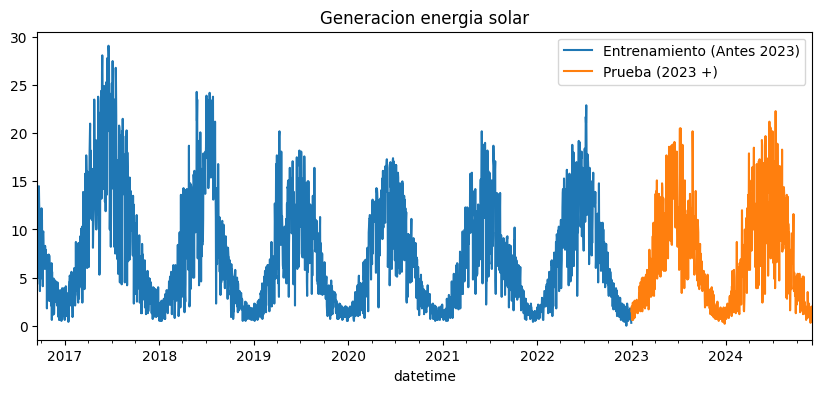

In [15]:
tstart = 2016
tend = 2022

# Columnas a usar como características
features_names = ["tempmax", "tempmin", "temp", "cloudcover", "solarradiation", "uvindex", "sunshine_hours", "solarenergy"]
target_name = "solarenergy"

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", target_name].plot(figsize=(10, 4), legend=True)
    dataset.loc[f"{tend+1}":, target_name].plot(figsize=(10, 4), legend=True)
    plt.legend([f"Entrenamiento (Antes {tend+1})", f"Prueba ({tend+1} +)"])
    plt.title("Generacion energia solar")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [16]:
#Creamos datos de entrenamiento
def train_test_split(dataset, tstart, tend, features_names):
    #Todos los datos entre el tstart y tend
    train = dataset.loc[f"{tstart}":f"{tend}", features_names].values
    #Todos los datos despues de tend
    test = dataset.loc[f"{tend+1}":, features_names].values
    return train, test

# Dividir en entrenamiento y prueba
training_set, test_set = train_test_split(dataset, tstart, tend, features_names)

# Escalar datos entre 0 y 1 para todas las características
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(training_set)

def split_sequence(sequence, n_steps):

    X, y = list(), list()

    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x) #Agrega la serie de valores
        y.append(seq_y) #Agregar el valor siguiente de la serie

    return np.array(X), np.array(y)


n_steps = 20 #Numero de datos historicos que toma en cuenta
features = len(features_names)
# split into samples
X_train, y_train = split_sequence(train_scaled, n_steps)

# Ajustar la forma para entrada en RNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))

In [17]:
#Guardo el Scaler
joblib.dump(scaler, "scaler2.pkl")

['scaler2.pkl']

In [18]:
#Configuro el Experimento en MLFLow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("mlflow-tensorflow-uk-generation-energy")

<Experiment: artifact_location='mlflow-artifacts:/243148812967294525', creation_time=1733518641642, experiment_id='243148812967294525', last_update_time=1733518641642, lifecycle_stage='active', name='mlflow-tensorflow-uk-generation-energy', tags={}>

In [21]:
# Configuro el nombre único del run
name = "tensorflow_series_UK_generation_energy" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

# Inicio del experimento en MLFlow
with mlflow.start_run(run_name=name) as run:
    
    # Registro hiperparámetros
    mlflow.log_param("model_type", "GRU")
    mlflow.log_param("units", 200)
    mlflow.log_param("activation", "tanh")
    mlflow.log_param("optimizer", "RMSprop")
    mlflow.log_param("loss", "mae")
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 50)

    #Arquitetura GRU
    model = Sequential([
        GRU(units=200, activation="tanh", input_shape=(n_steps, features)),
        Dense(units=1)
    ])

    model.compile(optimizer='RMSprop', loss='mae', metrics=["accuracy", "mse"])

    # Early stopping para evitar sobreajuste
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.25,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping,mlflowKeras.MlflowCallback()],
       verbose=1
    )

    # Registra métricas (últimos valores)
    mlflow.log_metric("final_loss", history.history['loss'][-1])
    mlflow.log_metric("final_val_loss", history.history['val_loss'][-1])
    mlflow.log_metric("final_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("final_val_accuracy", history.history['val_accuracy'][-1])

    # Definir las columnas de entrada para la predicción
    input_schema = Schema([
        TensorSpec(np.dtype(np.float16),(-1,), name="tempmax"),  # float16 → float
        TensorSpec(np.dtype(np.float16),(-1,), name="tempmin"),  # float16 → float
        TensorSpec(np.dtype(np.float16),(-1,), name="temp"), # float16 → float
        TensorSpec(np.dtype(np.float32),(-1,), name="cloudcover"), # float32 → float
        TensorSpec(np.dtype(np.float32),(-1,), name="solarradiation"), # float32 → float
        TensorSpec(np.dtype(np.int8),(-1,), name="uvindex"),  # int8 → integer
        TensorSpec(np.dtype(np.float16),(-1,), name="sunshine_hours"), # float16 → float
    ])

    # Definir las columnas de salida
    output_schema = Schema([
        TensorSpec(np.dtype(np.float32), (-1,), name="solarenergy")
    ])

    # Crear la firma del modelo
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    # Grafico las métricas de pérdida
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.title("Training and Validation Loss")
    plt.savefig("training_validation_loss.png")
    plt.close()

    # Registrando el gráfico de perdida como un artefacto
    mlflow.log_artifact("training_validation_loss.png")
    mlflow.log_artifact("scaler2.pkl")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.0058 - loss: 0.2008 - mse: 0.0717 - val_accuracy: 0.0101 - val_loss: 0.1635 - val_mse: 0.0451
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0073 - loss: 0.1558 - mse: 0.0430 - val_accuracy: 0.0101 - val_loss: 0.1654 - val_mse: 0.0448
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0090 - loss: 0.1574 - mse: 0.0443 - val_accuracy: 0.0103 - val_loss: 0.1633 - val_mse: 0.0442
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0084 - loss: 0.1557 - mse: 0.0435 - val_accuracy: 0.0099 - val_loss: 0.1642 - val_mse: 0.0445
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0065 - loss: 0.1554 - mse: 0.0435 - val_accuracy: 0.0103 - val_loss: 0.1619 - val_mse: 0.0441
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy:

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


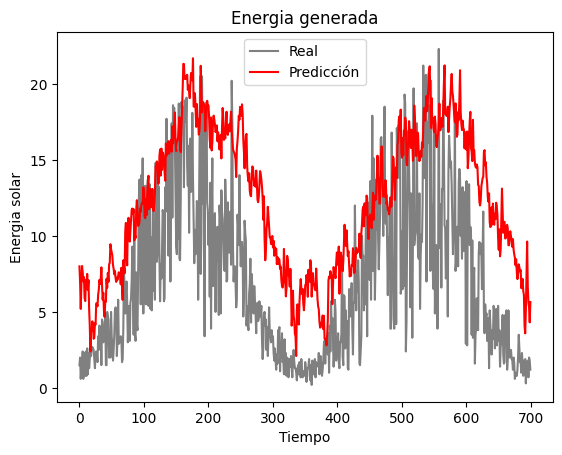

In [22]:
#Tomanos en la variable dataset_total todos los datos High del set de datos
dataset_total = dataset.loc[:, features_names].values

#extrae del dataset los datos para pruebas: total de datos-datos de prubeba - cantidad de historico
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :]

inputs = inputs.reshape(-1, features)
features = len(features_names)

inputs = scaler.transform(inputs)

X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

#Se hace la prediccion
predictions = model.predict(X_test)

# Seleccionar únicamente la columna de interes
y_test = y_test[:, -1]

# Crear un placeholder con la misma cantidad de filas que y_test
placeholder = np.zeros((y_test.shape[0], features - 1))  # Ajustar según las características, excluyendo la objetivo

# Concatenar para preparar los datos para la desnormalización
y_test_combined = np.concatenate((placeholder, y_test.reshape(-1, 1)), axis=1)
y_test_actual = scaler.inverse_transform(y_test_combined)[:, -1]

# Repetir para las predicciones
pred_combined = np.concatenate((placeholder, predictions.reshape(-1, 1)), axis=1)
pred_actual = scaler.inverse_transform(pred_combined)[:, -1]

plt.plot(y_test_actual, color="gray", label="Real")
plt.plot(pred_actual, color="red", label="Predicción")
plt.title("Energia generada")
plt.xlabel("Tiempo")
plt.ylabel("Energia solar")
plt.legend()
plt.show()

In [23]:
# Evaluar el modelo
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Evaluación del modelo:")
print(f"MAE (Error Absoluto Medio): {mae}")
print(f"MSE (Error Cuadrático Medio): {mse}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse}")
print(f"R² (Coeficiente de determinación): {r2}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluación del modelo:
MAE (Error Absoluto Medio): 0.1875438094139099
MSE (Error Cuadrático Medio): 0.046160247176885605
RMSE (Raíz del Error Cuadrático Medio): 0.2148493528366089
R² (Coeficiente de determinación): -0.4855877161026001


In [77]:
!conda env export > environment2.yml

In [78]:
!pip freeze > "./requirements2.txt"

In [24]:
env = {
  "name": "UKGenerationEnergyEnviroment",
  "channels": [
    "conda-forge",
    "defaults"
  ],
  "dependencies": [
    "_libgcc_mutex=0.1=conda_forge",
    "_openmp_mutex=4.5=2_gnu",
    "anaconda-anon-usage=0.4.4=py312hfc0e8ea_100",
    "archspec=0.2.3=pyhd3eb1b0_0",
    "boltons=23.0.0=py312h06a4308_0",
    "brotli-python=1.0.9=py312h6a678d5_8",
    "bzip2=1.0.8=h5eee18b_6",
    "c-ares=1.19.1=h5eee18b_0",
    "ca-certificates=2024.8.30=hbcca054_0",
    "certifi=2024.8.30=pyhd8ed1ab_0",
    "cffi=1.16.0=py312h5eee18b_1",
    "charset-normalizer=3.3.2=pyhd3eb1b0_0",
    "conda=24.7.1=py312h7900ff3_0",
    "conda-content-trust=0.2.0=py312h06a4308_1",
    "conda-libmamba-solver=24.7.0=pyhd3eb1b0_0",
    "conda-package-handling=2.3.0=py312h06a4308_0",
    "conda-package-streaming=0.10.0=py312h06a4308_0",
    "cryptography=42.0.5=py312hdda0065_1",
    "distro=1.9.0=py312h06a4308_0",
    "expat=2.6.2=h6a678d5_0",
    "fmt=9.1.0=hdb19cb5_1",
    "frozendict=2.4.2=py312h06a4308_0",
    "icu=73.1=h6a678d5_0",
    "idna=3.7=py312h06a4308_0",
    "jsonpatch=1.33=py312h06a4308_1",
    "jsonpointer=2.1=pyhd3eb1b0_0",
    "krb5=1.20.1=h143b758_1",
    "ld_impl_linux-64=2.38=h1181459_1",
    "libarchive=3.6.2=hfab0078_4",
    "libcurl=8.7.1=h251f7ec_0",
    "libedit=3.1.20230828=h5eee18b_0",
    "libev=4.33=h7f8727e_1",
    "libexpat=2.6.2=h59595ed_0",
    "libffi=3.4.4=h6a678d5_1",
    "libgcc=14.1.0=h77fa898_1",
    "libgcc-ng=14.1.0=h69a702a_1",
    "libgomp=14.1.0=h77fa898_1",
    "libmamba=1.5.8=hfe524e5_2",
    "libmambapy=1.5.8=py312h2dafd23_2",
    "libnghttp2=1.57.0=h2d74bed_0",
    "libnsl=2.0.1=hd590300_0",
    "libsolv=0.7.24=he621ea3_1",
    "libsqlite=3.46.0=hde9e2c9_0",
    "libssh2=1.11.0=h251f7ec_0",
    "libstdcxx-ng=11.2.0=h1234567_1",
    "libuuid=2.38.1=h0b41bf4_0",
    "libxcrypt=4.4.36=hd590300_1",
    "libxml2=2.13.1=hfdd30dd_2",
    "libzlib=1.2.13=h4ab18f5_6",
    "lz4-c=1.9.4=h6a678d5_1",
    "menuinst=2.1.2=py312h06a4308_0",
    "ncurses=6.4=h6a678d5_0",
    "openssl=3.3.2=hb9d3cd8_0",
    "packaging=24.1=py312h06a4308_0",
    "pcre2=10.42=hebb0a14_1",
    "pip=24.2=pyh8b19718_1",
    "platformdirs=3.10.0=py312h06a4308_0",
    "pluggy=1.0.0=py312h06a4308_1",
    "pybind11-abi=5=hd3eb1b0_0",
    "pycosat=0.6.6=py312h5eee18b_1",
    "pycparser=2.21=pyhd3eb1b0_0",
    "pysocks=1.7.1=py312h06a4308_0",
    "python=3.12.2=hab00c5b_0_cpython",
    "python_abi=3.12=5_cp312",
    "readline=8.2=h5eee18b_0",
    "reproc=14.2.4=h6a678d5_2",
    "reproc-cpp=14.2.4=h6a678d5_2",
    "requests=2.32.3=py312h06a4308_0",
    "ruamel.yaml=0.17.21=py312h5eee18b_0",
    "setuptools=72.1.0=py312h06a4308_0",
    "sqlite=3.45.3=h5eee18b_0",
    "tk=8.6.14=h39e8969_0",
    "tqdm=4.66.4=py312he106c6f_0",
    "truststore=0.8.0=py312h06a4308_0",
    "tzdata=2024a=h04d1e81_0",
    "urllib3=2.2.2=py312h06a4308_0",
    "wheel=0.43.0=py312h06a4308_0",
    "xz=5.4.6=h5eee18b_1",
    "yaml-cpp=0.8.0=h6a678d5_1",
    "zlib=1.2.13=h4ab18f5_6",
    "zstandard=0.22.0=py312h2c38b39_0",
    "zstd=1.5.5=hc292b87_2",
    {
      "pip": [
        "applicationinsights==0.11.10",
        "psutil==6.0.0"
      ]
    }
  ],
  "prefix": "/anaconda"
}

In [25]:
#Guardando el modelo
model_path = "./models/tensorflow_series_UK_generation_energy"
#mlflow.keras.save_model(model, model_path,signature=signature, conda_env=env, pip_requirements="./requirements2.txt")

In [26]:
# Cargo el workspace configurado
workspace = Workspace.from_config()

# Registro el modelo en el workspace
registered_model = Model.register(
    workspace=workspace,
    model_name="tensorflow_series_UK_generation_energy",
    model_path=model_path,  # Ruta local donde se guardó el modelo
    description="Modelo GRU para la prediccion de generación de energia en UK"
)

print(f"Modelo registrado con ID: {registered_model.id}")

Registering model tensorflow_series_UK_generation_energy
Modelo registrado con ID: tensorflow_series_UK_generation_energy:2


In [ ]:
ngrok.kill()